# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [110]:
import pandas as pd
import numpy as np
import plotnine as p9
from palmerpenguins import load_penguins

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [111]:
# Code Here
dataset = load_penguins().dropna()

X = dataset.drop("bill_depth_mm", axis = 1)
y =  dataset["bill_depth_mm"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y)

In [112]:
num_cols = ["bill_length_mm","flipper_length_mm","body_mass_g"]
cat_cols = ["species","island","year"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale",  StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
).set_output(transform="pandas")

lr_pipeline = Pipeline(
  [("preprocessing", preprocess),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [113]:
model_lr = lr_pipeline.fit(X_train,y_train)

lr_flex = 1

LR_train_MSE = mean_squared_error(y_train, model_lr.predict(X_train))
LR_test_MSE = mean_squared_error(y_test, model_lr.predict(X_test))

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [114]:
knn_pipe = Pipeline([
    ("preprocess", preprocess),
    ("KNN", KNeighborsRegressor(n_neighbors=5))
]).set_output(transform="pandas")


param_grid = {
    "KNN__weights": ["uniform", "distance"],
    "KNN__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

gs = GridSearchCV(knn_pipe, param_grid, cv=5,
                  scoring="neg_root_mean_squared_error", n_jobs = -1)

In [115]:
gs.fit(X_train, y_train)

best = gs.best_estimator_
yhat = best.predict(X_test)

gs.best_params_

{'KNN__p': 2, 'KNN__weights': 'distance'}

In [116]:
tuned_knn_pipeline1 = Pipeline([
    ("preprocess", preprocess),
    ("KNN", KNeighborsRegressor(n_neighbors=1,p = 2, weights= "distance"))
]).set_output(transform="pandas")

In [117]:
Model_knn1 = tuned_knn_pipeline1.fit(X_train, y_train)

knn1_flex = 5
knn1_train_MSE = mean_squared_error(y_train, Model_knn1.predict(X_train))
knn1_test_MSE = mean_squared_error(y_test, Model_knn1.predict(X_test))

In [118]:
knn_pipe2 = Pipeline([
    ("preprocess", preprocess),
    ("KNN", KNeighborsRegressor(n_neighbors=10))
]).set_output(transform="pandas")

In [119]:
gs_2 = GridSearchCV(knn_pipe2, param_grid, cv=5,
                  scoring="neg_root_mean_squared_error", n_jobs = -1)

gs_2.fit(X_train, y_train)

best2 = gs.best_estimator_
yhat2 = best2.predict(X_test)

gs_2.best_params_

{'KNN__p': 2, 'KNN__weights': 'distance'}

In [120]:
tuned_knn_pipeline2 = Pipeline([
    ("preprocess", preprocess),
    ("KNN", KNeighborsRegressor(n_neighbors=10,p = 2, weights= "distance"))
]).set_output(transform="pandas")

In [121]:
Model_knn2 = tuned_knn_pipeline2.fit(X_train, y_train)

knn2_flex = 10
knn2_train_MSE = mean_squared_error(y_train, Model_knn2.predict(X_train))
knn2_test_MSE = mean_squared_error(y_test, Model_knn2.predict(X_test))

In [122]:
Tree_pipeline = Pipeline ([
    ("preprocess", preprocess),
    ("tree", DecisionTreeRegressor(random_state=12))
]).set_output(transform="pandas")

In [123]:
param_grid2 = {
    "tree__max_depth": [1, 3, 5, 8, 12, 20],
    "tree__min_samples_split": [2, 5, 10, 20],
    "tree__min_samples_leaf": [1, 2, 5, 10],
    "tree__max_features": [None, "sqrt", "log2"],}


gs2 = GridSearchCV(
    Tree_pipeline, param_grid2, cv=5,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['bill_length_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['species',
                                                                          'island',
                                                                          'year'])])),
                                       ('tree',
                                        DecisionTreeRegressor(random_state=12))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 3, 5, 8, 12, 20],
                         'tree__max_features': [None, 'sqrt', 'log2'],
                         'tree__min_samples_leaf': [1, 2, 5, 10],
                         'tree__min_samples_split': [2, 5, 10, 20]},
             scoring='neg_root_mean_squared_error')

In [124]:
gs2.best_params_

{'tree__max_depth': 5,
 'tree__max_features': None,
 'tree__min_samples_leaf': 10,
 'tree__min_samples_split': 2}

In [125]:
tuned_tree_pipeline = Pipeline ([
    ("preprocess", preprocess),
    ("tree", DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=2))
]).set_output(transform="pandas")

In [126]:
Model_tree = tuned_tree_pipeline.fit(X_train, y_train)

tree_flex = 8

tree_train_MSE = mean_squared_error(y_train, Model_tree.predict(X_train))
tree_test_MSE = mean_squared_error(y_test, Model_tree.predict(X_test))

In [127]:
data_sum = {
    "model": ["LR", "KNN1", "KNN2", "Tree"],
    "Flex" : [lr_flex, knn1_flex, knn2_flex, tree_flex],
    "MSE_train" : [LR_train_MSE, knn1_train_MSE, knn2_train_MSE, tree_train_MSE],
    "MSE_test" : [LR_test_MSE, knn1_test_MSE, knn2_test_MSE, tree_test_MSE]
}

summary = pd.DataFrame(data_sum).sort_values("Flex")

Long = summary.melt(id_vars=["model","Flex"],
                    value_vars = ["MSE_train", "MSE_test"],
                    var_name= "split", 
                    value_name="MSE"
)
Long["split"] = Long["split"].str.replace("_mse","", regex=False)

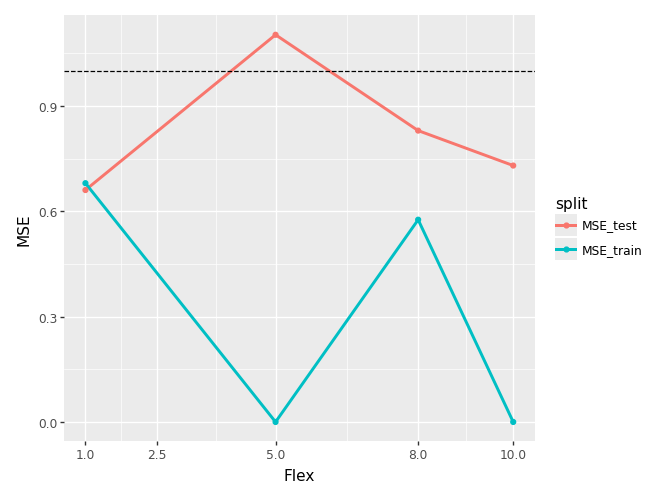

In [128]:
(p9.ggplot(Long, p9.aes("Flex", "MSE", color = "split", group = "split"))
+p9.geom_line(size = 1.2)
+p9.geom_hline(yintercept = 1, linetype = "dashed")
+p9.scale_x_continuous(breaks=[1,2.5,5,8,10,15])
+p9.geom_point())

The best model could have been ethier of the KNN models however i beleive their scores are not accurate as computing zero should not be possible and would mean that the model is absolutely perfect at predicting everything with no errors. 